# Introduction
- My report is for those who are planning to start a new restaurant in the city of Toronto. I will provide a suggestion for the best venue to start a new restaurant in a highly visited city with already many good people.
- Toronto, city, capital of the province of Ontario, southeastern Canada. It is the most populous city in Canada, a multicultural city, and the country’s financial and commercial center. Its location on the northwestern shore of Lake Ontario, which forms part of the border between Canada and the United States, and its access to Atlantic shipping via the St. Lawrence Seaway and to major U.S. industrial centers via the Great Lakes have enabled Toronto to become an important international trading center. Moreover, the city is positioned on the edge of some of the best farmland in Canada, with a climate favorable to growing a wide range of crops, thereby making Toronto a transportation, distribution, and manufacturing center. Most importantly, its central location, along with a host of political policies favoring international trade, places this city with the greatest economic ties to, and influence from, the United States. 

# Business Problem
In this report, I will focus on the issue of where to open a new restaurant in a city like Toronto. At first, I will check the information, and the first important decision will be the location for its new restaurant.
1. What is the basis that can decide its new restaurant's location?
2. While selecting the place, there are key points to consider like they need to check out like where the most well-visited venues of the city are?
3. If incase there are already other luxury restaurants that have good ratings, will it be risky to open a new one near these restaurants?

# Data Setup
Next step, I would use Foursquare API that as its prime data gathering as it has a database of place. The API can provide the ability to perform location search, location sharing, and information business details. 
I would use HTTP request limitations, the number of places per neighborhood parameter would reasonably beset to 100, and the radius parameter set to 1000. 
Another step is to search the other restaurants, the neighborhood information, and the restau rating for comparison to find a suitable location opening the new restaurant. 
The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

1. Number of neighborhood
1. Latitude and Longitude of restaurant in each venue
3. Name of the venue e.g. the name of a store or restaurant

# Analysis
We will discuss data with libraries python are following.
- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of Toronto.
- folium to visualize the results on a map


# 1. Import code from week 3

In [1]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import requests
import pandas as pd
from pandas.io.html import read_html
import numpy as np
from bs4 import BeautifulSoup
import requests
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Libraries imported.')

print('Code in Week 3 ')
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

wikitables = read_html(url, attrs={'class':'wikitable'})

tables = wikitables[0]
tables.columns = tables.iloc[0]
tables.head()
new_tables = tables.drop((tables.index[0]))

#Clean Data
new_tables.head()
new_tables_drop = new_tables[new_tables.Borough != 'Not assigned']
new_tables_drop = new_tables_drop.reset_index(drop=True)
new_tables_drop.head()

clean_table = new_tables_drop.groupby(['Postcode','Borough'], sort=False).agg( ', '.join)
clean_table_new=clean_table.reset_index()
clean_table_new.head(15)

!wget -q -O 'Geospatial_Coordinates.csv'  http://cocl.us/Geospatial_data
df_Geospatial_Coordinates = pd.read_csv('Geospatial_Coordinates.csv')
df_Geospatial_Coordinates.head()
df_Geospatial_Coordinates.columns=['Postcode','Latitude','Longitude']

#Merge in Postcode
df_Toronto = pd.merge(clean_table_new,
                 df_Geospatial_Coordinates[['Postcode','Latitude', 'Longitude']],
                 on='Postcode')

#rename Neighbourhood
df_Toronto.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

df_Toronto.head(9)

Libraries imported.
Code in Week 3 


'wget' is not recognized as an internal or external command,
operable program or batch file.


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Not assigned,43.662301,-79.389494
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937


Now, I define three function for search the location in foursquare that are following
1. geo_location - setup the llatitude and longitude
2. get_venues - search other venues in radius and set limit 
3. get_venues_details - collect the information of venues

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'WTBSCNK13HSJO1KLQ0PAUNLY3D2OVOMKWJ11ZWTBJNGGB14S' # your Foursquare ID
    CLIENT_SECRET = 'IRRDOTXCOBB1NWBG52GVZAOSL1ENVMSFZCFZD1UVUZNU13NJ' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'WTBSCNK13HSJO1KLQ0PAUNLY3D2OVOMKWJ11ZWTBJNGGB14S' # your Foursquare ID
    CLIENT_SECRET = 'IRRDOTXCOBB1NWBG52GVZAOSL1ENVMSFZCFZD1UVUZNU13NJ' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the toronto data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate are {}, {}.'.format(latitude_x, longitude_y))
print(df_Toronto.shape)


D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate are 43.653963, -79.387207.
(103, 5)


In [6]:
df_Toronto.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Not assigned,43.662301,-79.389494
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


Create Borough Plot

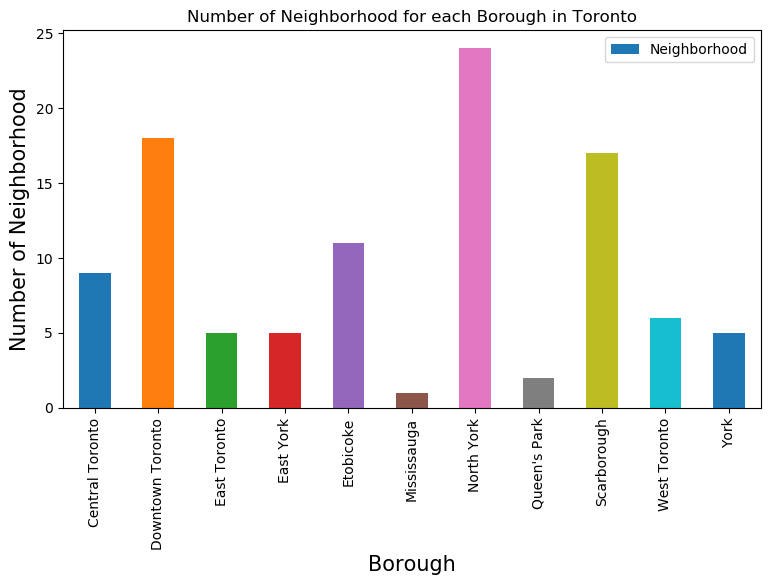

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhood', fontsize=15)
#giving a bar plot
df_Toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now, we can find the resurants in each borough

In [8]:
a, b, c, d, e = df_Toronto.values.tolist()[0]
print('{}, {}, {}'.format(a,b,c))

M3A, North York, Parkwoods


In [54]:
# prepare neighborhood list that contains resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Total_Resturants=pd.DataFrame(columns=column_names)
count=1
for row in df_Toronto.values.tolist():
    Postcode ,Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Resturants=venues[venues['Category']=='Restaurant']   
    print('(',count,'/',len(df_Toronto),')',' Resturants in '+Neighborhood+', '+Borough+' : '+str(len(Resturants)))
    for resturant_detail in Resturants.values.tolist():
        code, name , category = resturant_detail
        Total_Resturants = Total_Resturants.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': code,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
        

( 1 / 103 )  Resturants in Parkwoods, North York : 0
( 2 / 103 )  Resturants in Victoria Village, North York : 0
( 3 / 103 )  Resturants in Harbourfront, Downtown Toronto : 4
( 4 / 103 )  Resturants in Lawrence Heights, Lawrence Manor, North York : 2
( 5 / 103 )  Resturants in Not assigned, Queen's Park : 2
( 6 / 103 )  Resturants in Queen's Park, Queen's Park : 0
( 7 / 103 )  Resturants in Rouge, Malvern, Scarborough : 0
( 8 / 103 )  Resturants in Don Mills North, North York : 1
( 9 / 103 )  Resturants in Woodbine Gardens, Parkview Hill, East York : 0
( 10 / 103 )  Resturants in Ryerson, Garden District, Downtown Toronto : 3
( 11 / 103 )  Resturants in Glencairn, North York : 2
( 12 / 103 )  Resturants in Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park, Etobicoke : 0
( 13 / 103 )  Resturants in Highland Creek, Rouge Hill, Port Union, Scarborough : 0
( 14 / 103 )  Resturants in Flemingdon Park, Don Mills South, North York : 3
( 15 / 103 )  Resturants in Woodbine 

In [10]:
Total_Resturants.head(15)

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,Harbourfront,5612b1cc498e3dd742af0dc8,Impact Kitchen
1,Downtown Toronto,Harbourfront,56423155498e78e89181cb44,Cluck Clucks
2,Downtown Toronto,Harbourfront,505bacb2e4b0474d876eb78c,Paintbox Bistro
3,Downtown Toronto,Harbourfront,4b0b115bf964a5205e2c23e3,The Chefs' House
4,North York,"Lawrence Heights, Lawrence Manor",4b3113e0f964a520b3ff24e3,Swiss Chalet Rotisserie & Grill
5,North York,"Lawrence Heights, Lawrence Manor",4af3820ef964a5203dee21e3,Shoeless Joe's
6,Queen's Park,Not assigned,4caf69ae9b34199c9a2ab763,Fabarnak
7,Queen's Park,Not assigned,4bdcc9cf462b2d7f1f65113c,Wish
8,North York,Don Mills North,4b53b917f964a52038a927e3,Swiss Chalet Rotisserie & Grill
9,Downtown Toronto,"Ryerson, Garden District",59246b5aad1789316b35d66c,JOEY Eaton Centre


In [11]:
Total_Resturants.shape

(121, 4)

Now, We got 116 Resturants in Toronto and represent the number of resturants for each Borough in Toronto

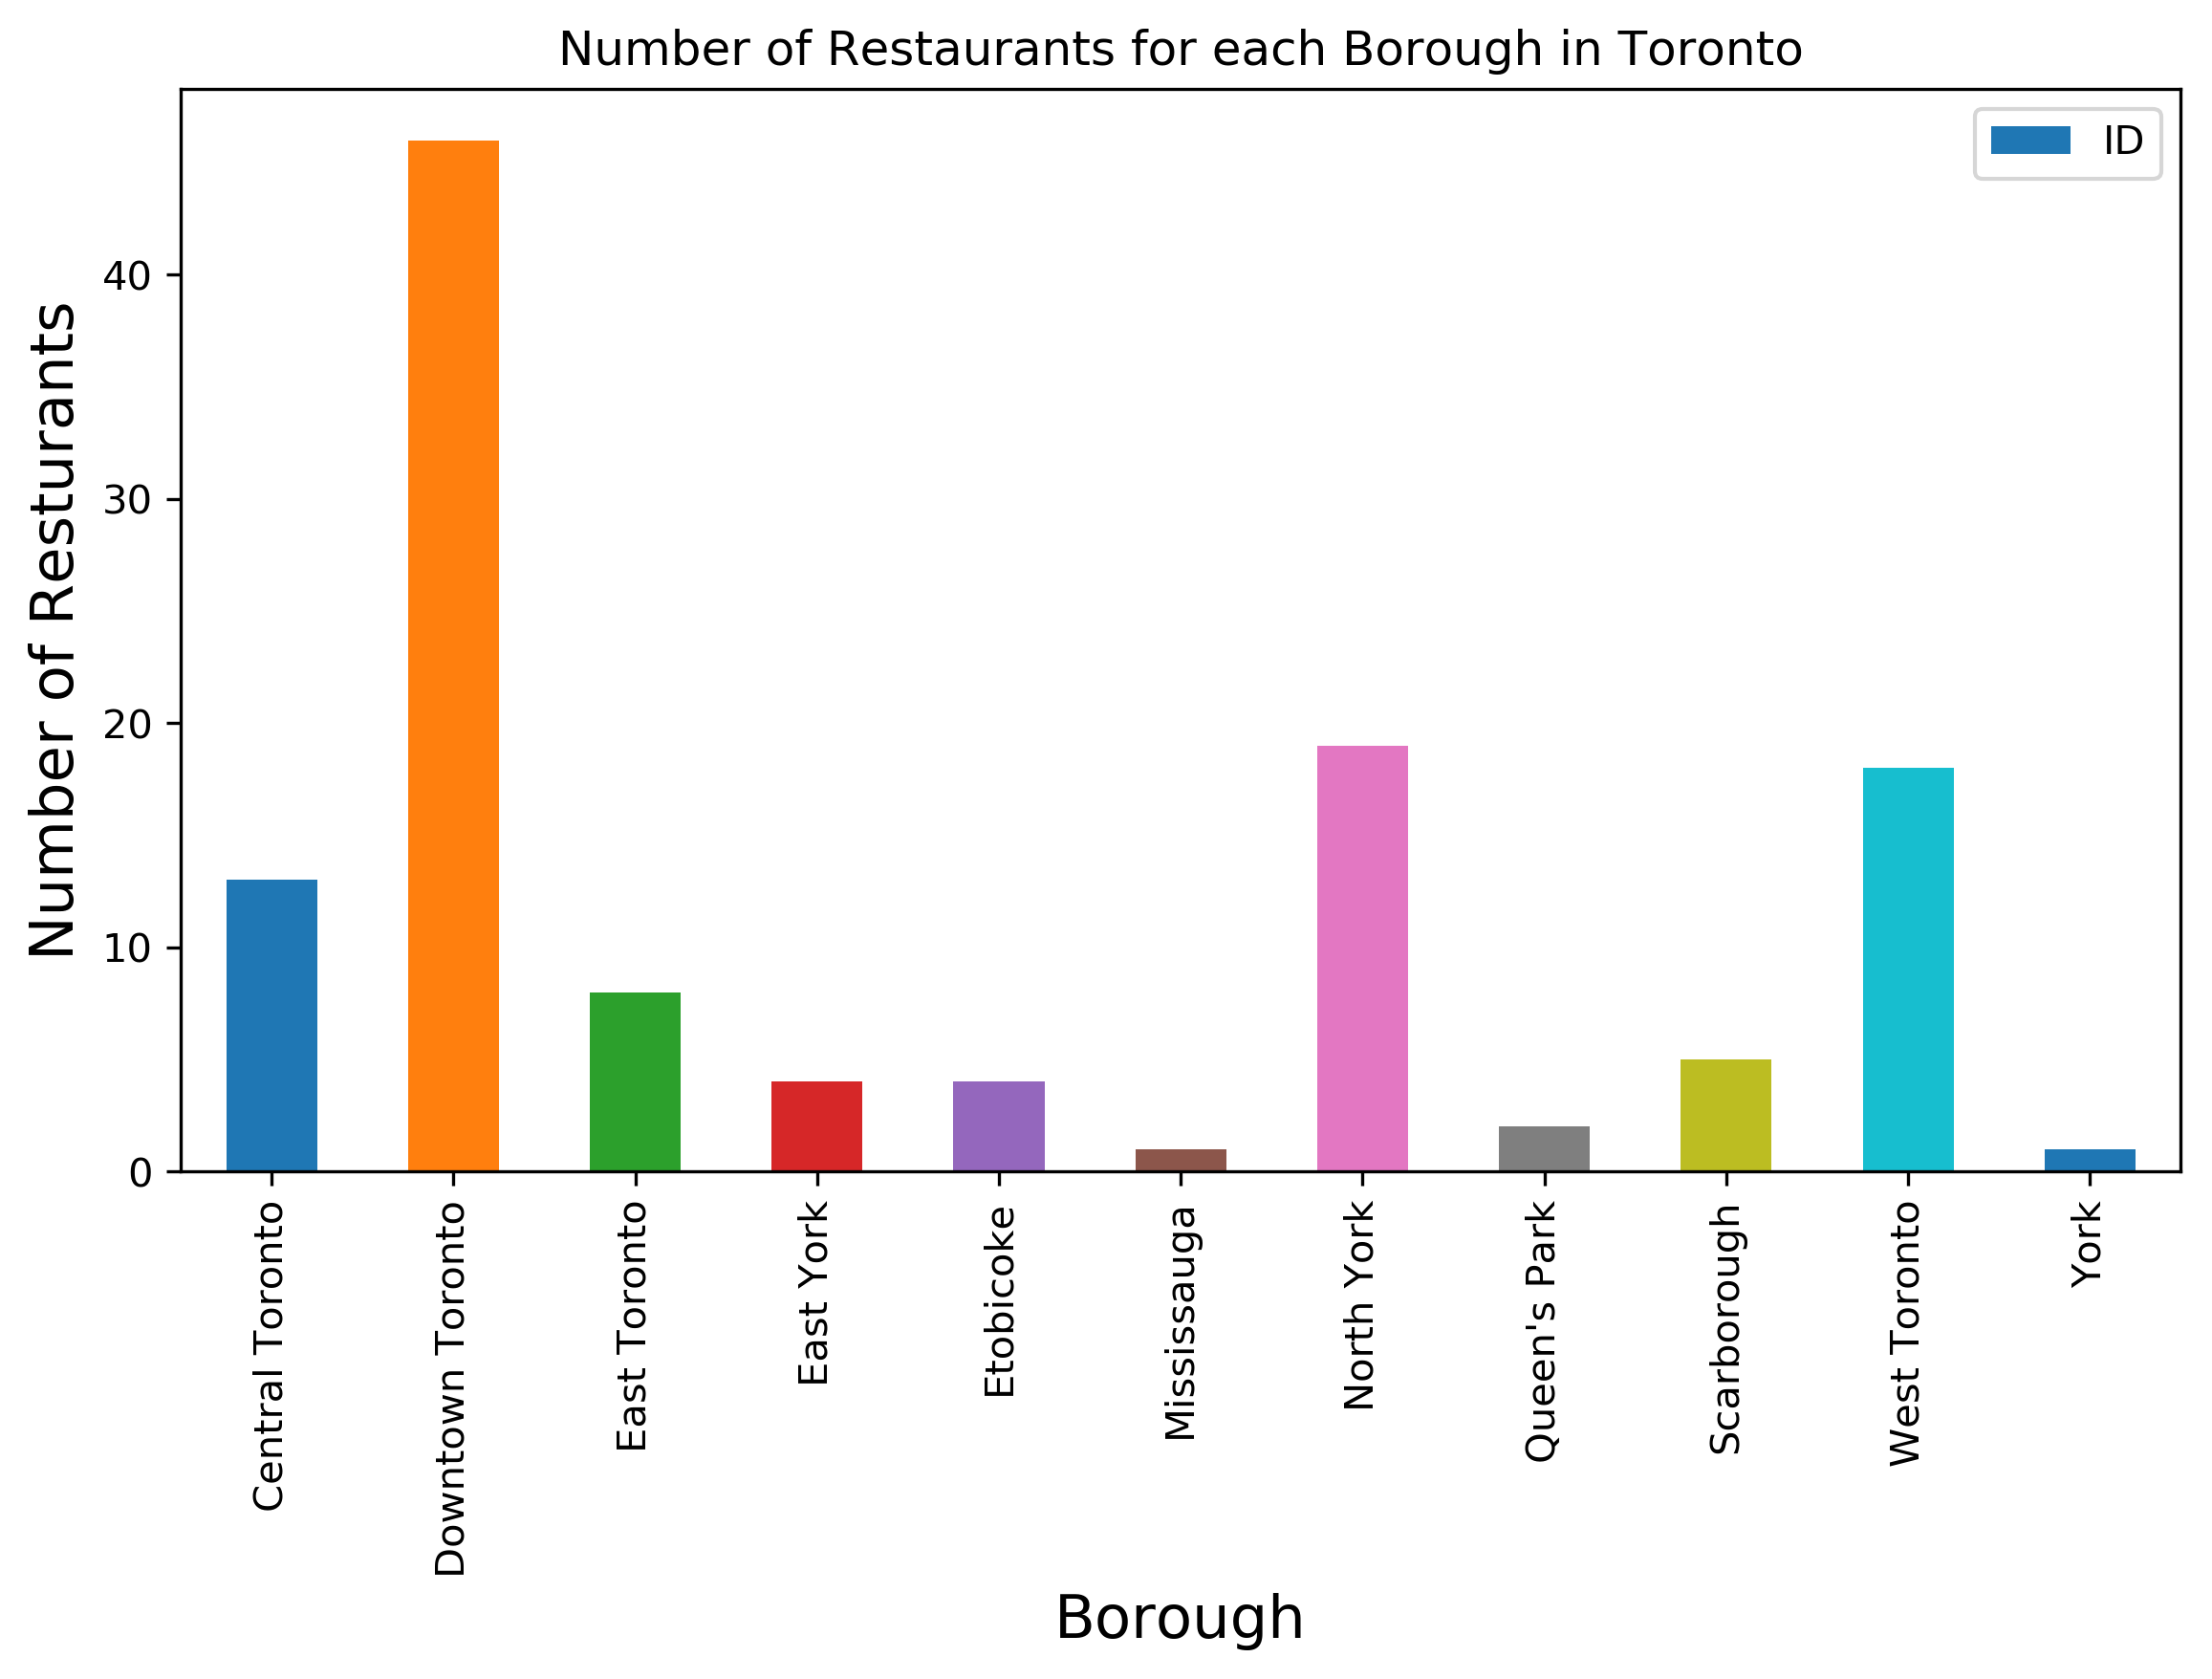

In [57]:
plt.figure(figsize=(9,5), dpi = 300)
# title
plt.title('Number of Restaurants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Resturants', fontsize=15)
#giving a bar plot
Total_Resturants.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

After that, We search the resturants for each neighborhood

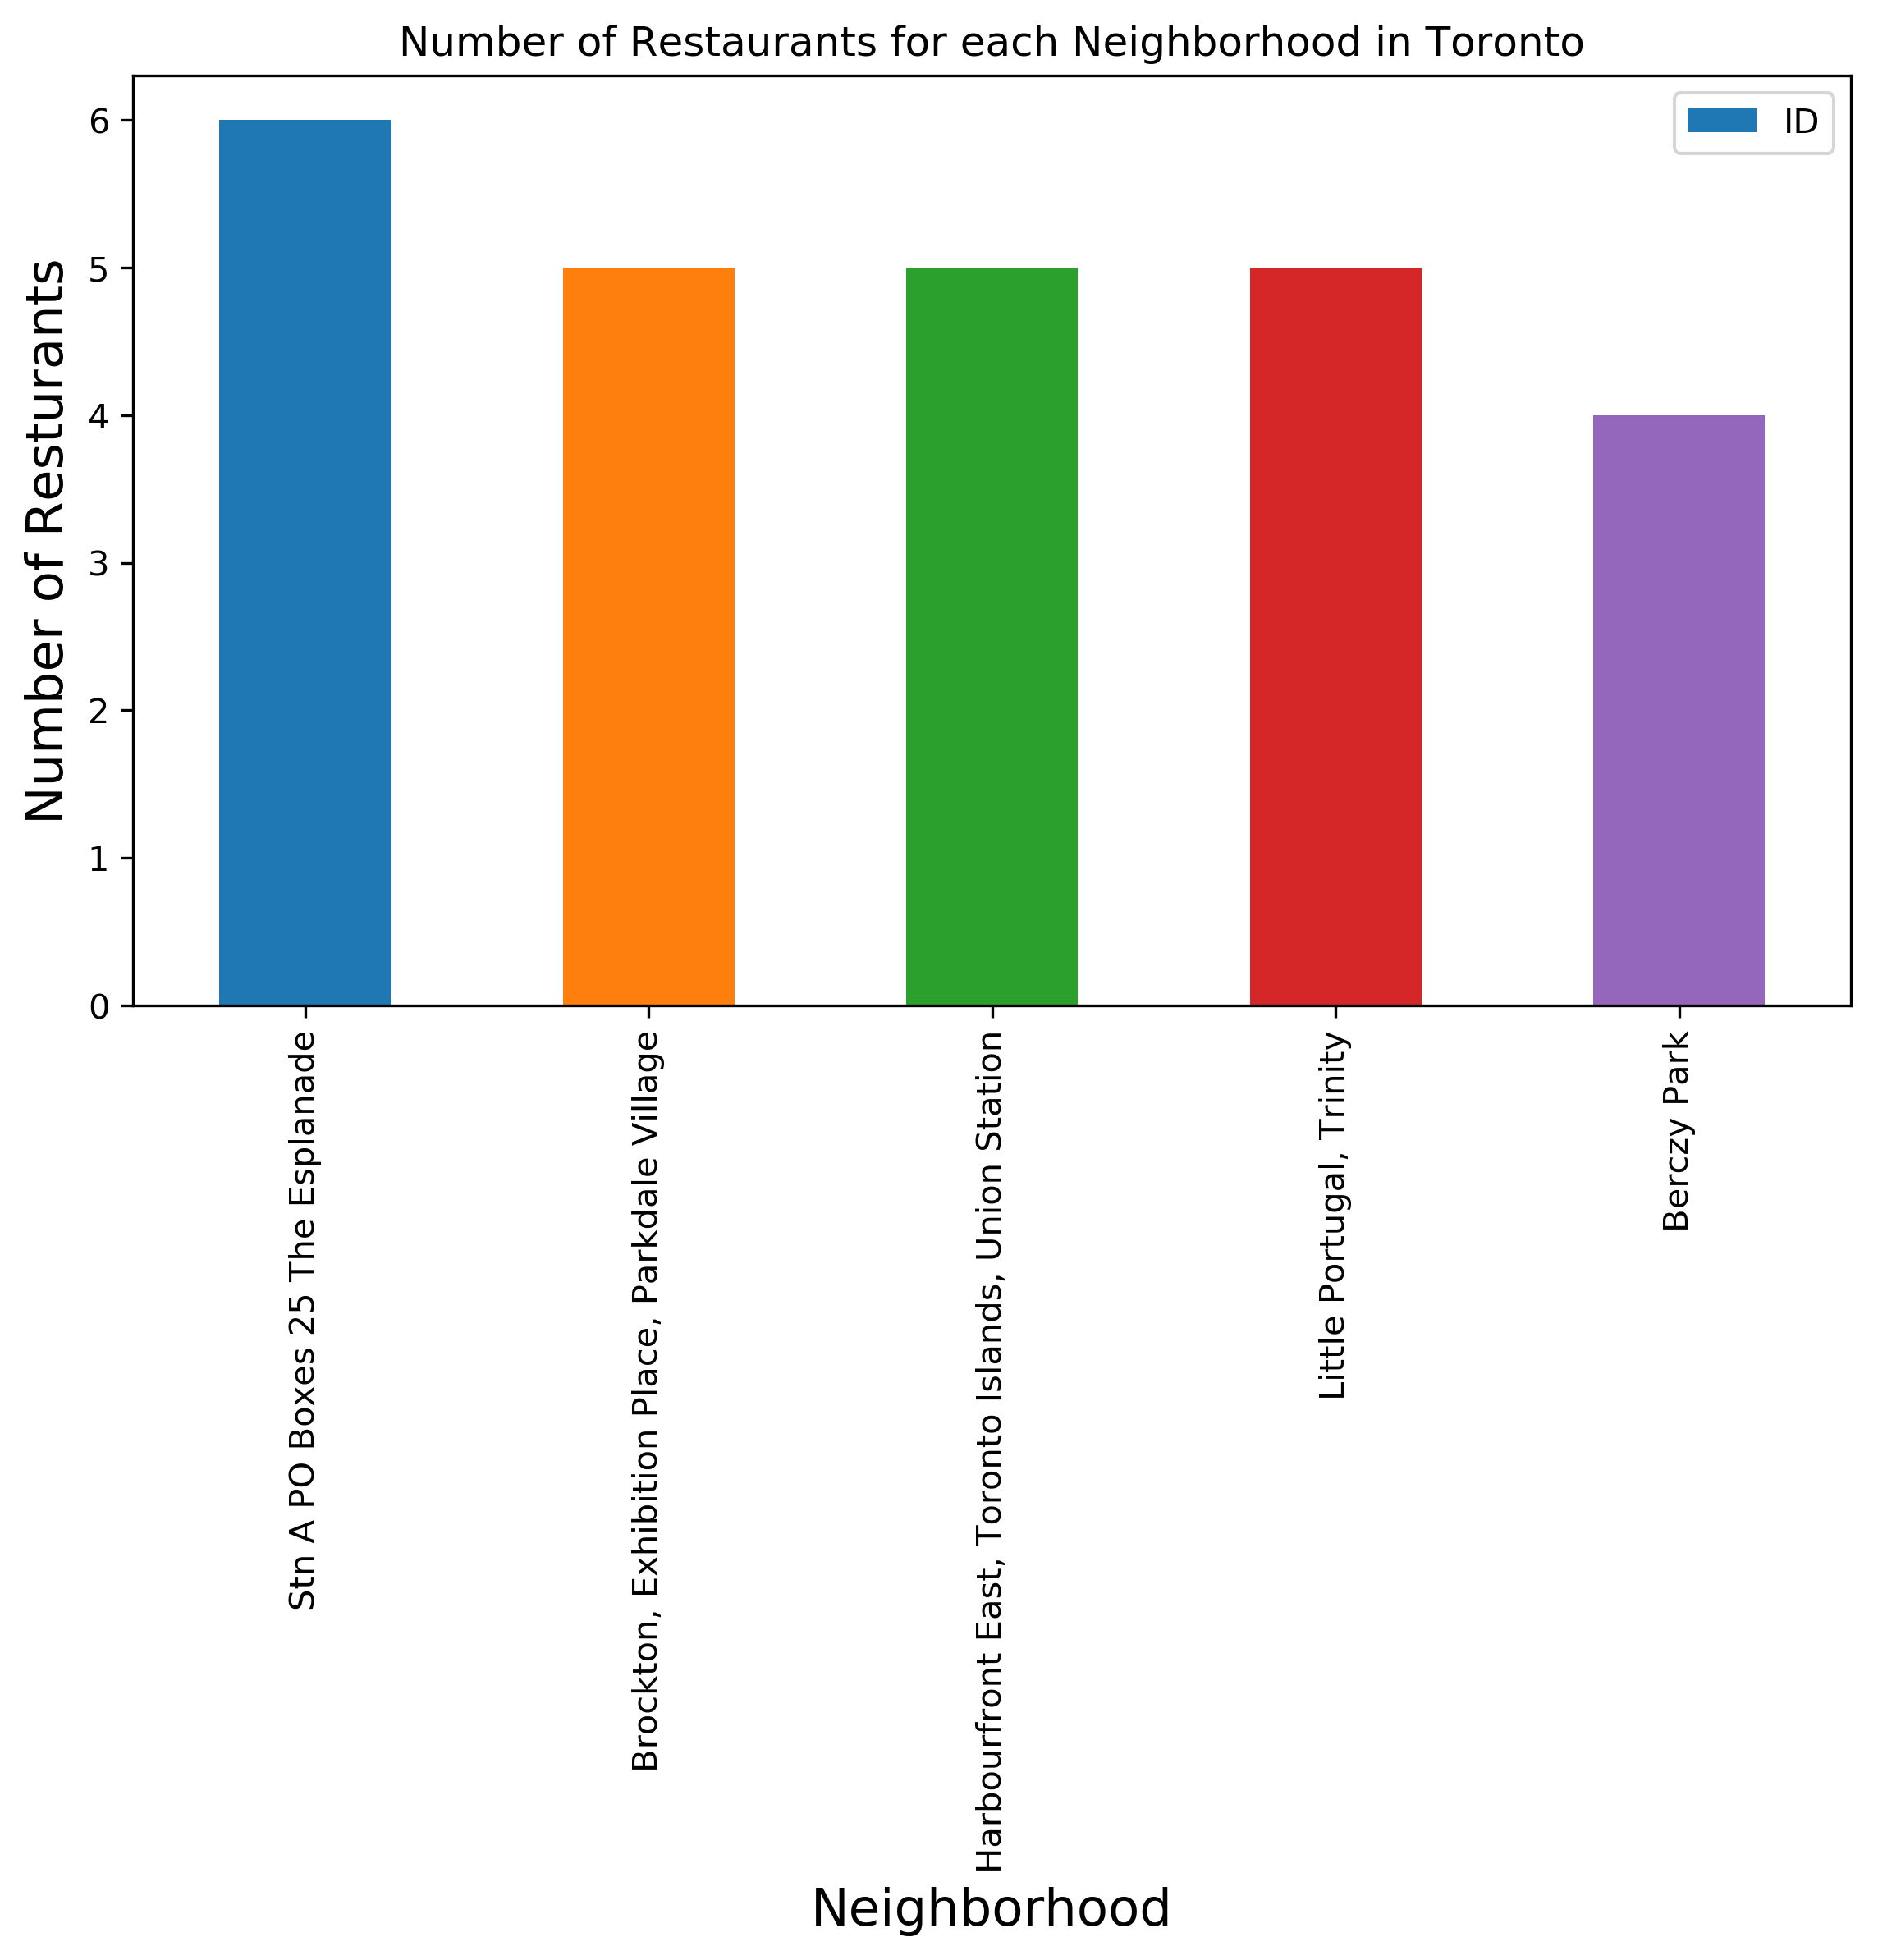

In [56]:
plt.figure(figsize=(9,5), dpi = 300)
# title
plt.title('Number of Restaurants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Resturants', fontsize=15)
#giving a bar plot
Total_Resturants.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [14]:
Total_Resturants[Total_Resturants['Neighborhood'] == 'Brockton, Exhibition Place, Parkdale Village']

,Borough,Neighborhood,ID,Name
56,West Toronto,"Brockton, Exhibition Place, Parkdale Village",4ad4c05ff964a52022f720e3,Medieval Times
57,West Toronto,"Brockton, Exhibition Place, Parkdale Village",5406814a498eef2f7025c13b,Nuit Social
58,West Toronto,"Brockton, Exhibition Place, Parkdale Village",4ce8ba46f865370410eab2c4,Vogue Supper Club
59,West Toronto,"Brockton, Exhibition Place, Parkdale Village",539a728d498e606f9b325dee,The Good Son
60,West Toronto,"Brockton, Exhibition Place, Parkdale Village",546bf555498ea560de6039e6,Dandylion


In [15]:
Total_Resturants[Total_Resturants['Neighborhood'] == 'Little Portugal, Trinity']

,Borough,Neighborhood,ID,Name
46,West Toronto,"Little Portugal, Trinity",57a7b76d498e40fabea0bc23,Montgomery's
47,West Toronto,"Little Portugal, Trinity",4b6cf195f964a5204c5f2ce3,Frankie's Bar & Cafe
48,West Toronto,"Little Portugal, Trinity",5af9ee1eff03060039db2be2,Founder Restaurant & Bar
49,West Toronto,"Little Portugal, Trinity",5248b5d711d224db20f7f541,Rhum Corner
50,West Toronto,"Little Portugal, Trinity",5406814a498eef2f7025c13b,Nuit Social


In [16]:
Total_Resturants[Total_Resturants['Neighborhood'] == 'St. James Town']

,Borough,Neighborhood,ID,Name
17,Downtown Toronto,St. James Town,4af618daf964a520220122e3,GEORGE Restaurant
18,Downtown Toronto,St. James Town,529e7344498e18bff5e60191,The Carbon Bar
19,Downtown Toronto,St. James Town,4ad4c05cf964a52006f620e3,Victoria's Restaurant
20,Downtown Toronto,St. James Town,4ad4c05df964a52059f620e3,Canoe


In [17]:
Total_Resturants[Total_Resturants['Neighborhood'] == 'Stn A PO Boxes 25 The Esplanade']

,Borough,Neighborhood,ID,Name
105,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,4ad4c05df964a52059f620e3,Canoe
106,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,4baa4b39f964a520ec5b3ae3,Marché Mövenpick
107,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,50fd7b1b582f9d035e57a426,The Works Gourmet Burger Bistro
108,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,4ad4c05cf964a52006f620e3,Victoria's Restaurant
109,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,4ae7199ff964a52068a821e3,Bymark
110,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,4af618daf964a520220122e3,GEORGE Restaurant


In [18]:
Total_Resturants[Total_Resturants['Neighborhood'] == 'Berczy Park']

,Borough,Neighborhood,ID,Name
23,Downtown Toronto,Berczy Park,4ad4c05df964a52059f620e3,Canoe
24,Downtown Toronto,Berczy Park,4baa4b39f964a520ec5b3ae3,Marché Mövenpick
25,Downtown Toronto,Berczy Park,50fd7b1b582f9d035e57a426,The Works Gourmet Burger Bistro
26,Downtown Toronto,Berczy Park,4ad4c05cf964a52006f620e3,Victoria's Restaurant


We discuss North York because The number of neighborhood more people than another neighborhood and lower restuarants.

In [19]:
Total_Resturants[Total_Resturants['Borough'] == 'North York']

,Borough,Neighborhood,ID,Name
4,North York,"Lawrence Heights, Lawrence Manor",4b3113e0f964a520b3ff24e3,Swiss Chalet Rotisserie & Grill
5,North York,"Lawrence Heights, Lawrence Manor",4af3820ef964a5203dee21e3,Shoeless Joe's
8,North York,Don Mills North,4b53b917f964a52038a927e3,Swiss Chalet Rotisserie & Grill
12,North York,Glencairn,52a1250a11d285bd7a3a5353,The West Wing Bar 'n Grill
13,North York,Glencairn,4c3cfac14bc9a5934e72d371,Sea Salt Fish & Chips
14,North York,"Flemingdon Park, Don Mills South",4b6315b6f964a520d6612ae3,Swiss Chalet Rotisserie & Grill
15,North York,"Flemingdon Park, Don Mills South",4c02b933310fc9b64fe1c461,JOEY Don Mills
16,North York,"Flemingdon Park, Don Mills South",4b4bd8c0f964a52078a926e3,Jack Astor's Bar & Grill
31,North York,"Bathurst Manor, Downsview North, Wilson Heights",4b65c410f964a52050fe2ae3,Bagel Plus
37,North York,"Fairview, Henry Farm, Oriole",5650fa8e498e405c38a5e6d4,Thai Express


In [20]:
Restuarant_North_York = Total_Resturants[Total_Resturants['Borough'] == 'North York']
Restuarant_North_York['Neighborhood'].describe()

count                                   19
unique                                  11
top       Flemingdon Park, Don Mills South
freq                                     3
Name: Neighborhood, dtype: object

Find the rating and Like in each restuarants

In [21]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Restuarants_stats=pd.DataFrame(columns=column_names)
count=1


for row in Total_Resturants.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Total_Resturants),')','processed')
    Restuarants_stats = Restuarants_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID            Name  Likes  Rating  Tips
0  5612b1cc498e3dd742af0dc8  Impact Kitchen     51     8.7     9
( 1 / 121 ) processed
                         ID          Name  Likes  Rating  Tips
0  56423155498e78e89181cb44  Cluck Clucks     29     8.0    10
( 2 / 121 ) processed
                         ID             Name  Likes  Rating  Tips
0  505bacb2e4b0474d876eb78c  Paintbox Bistro     25     7.4     9
( 3 / 121 ) processed
                         ID              Name  Likes  Rating  Tips
0  4b0b115bf964a5205e2c23e3  The Chefs' House     17     7.1    16
( 4 / 121 ) processed
                         ID                             Name  Likes  Rating  \
0  4b3113e0f964a520b3ff24e3  Swiss Chalet Rotisserie & Grill     15     7.5   

   Tips  
0     2  
( 5 / 121 ) processed
                         ID            Name  Likes  Rating  Tips
0  4af3820ef964a5203dee21e3  Shoeless Joe's     11     5.9     3
( 6 / 121 ) processed
                         ID      Name

KeyError: 'venue'

In [ ]:
Restuarants_stats.head(15)

So we got data for all resturants Now lets save this data to a csv sheet. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [22]:
Restuarants_stats.to_csv('Restuarants_stats_Toronto.csv', index=False)

In [23]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import requests
import pandas as pd
from pandas.io.html import read_html
import numpy as np
from bs4 import BeautifulSoup
import requests
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Libraries imported.')

Libraries imported.


In [24]:
Restuarants_stats_csv=pd.read_csv('Restuarants_stats_Toronto.csv')
Restuarants_stats_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Harbourfront,5612b1cc498e3dd742af0dc8,Impact Kitchen,51,8.7,9
1,Downtown Toronto,Harbourfront,56423155498e78e89181cb44,Cluck Clucks,29,8.0,10
2,Downtown Toronto,Harbourfront,505bacb2e4b0474d876eb78c,Paintbox Bistro,25,7.4,9
3,Downtown Toronto,Harbourfront,4b0b115bf964a5205e2c23e3,The Chefs' House,17,7.1,16
4,North York,"Lawrence Heights, Lawrence Manor",4b3113e0f964a520b3ff24e3,Swiss Chalet Rotisserie & Grill,15,7.5,2


In [25]:
Restuarants_stats_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null int64
Rating          50 non-null float64
Tips            50 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.8+ KB


Type of Likes and Tips is int64 that could change to float64 because we may use calculated in average like and tips

In [26]:
Restuarants_stats_csv['Likes']=Restuarants_stats_csv['Likes'].astype('float64')
Restuarants_stats_csv['Tips']=Restuarants_stats_csv['Tips'].astype('float64')
Restuarants_stats_csv['Borough']=Restuarants_stats_csv['Borough'].astype('str')

In [27]:
Restuarants_stats_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


We must find the maximum of Like, Rating and Tips

In [28]:
# Resturant with maximum Likes
Restuarants_stats_csv.iloc[Restuarants_stats_csv['Likes'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                 Berczy Park
ID              4baa4b39f964a520ec5b3ae3
Name                    Marché Mövenpick
Likes                                401
Rating                               7.8
Tips                                 142
Name: 24, dtype: object

In [29]:
# Resturant with maximum Rating
Restuarants_stats_csv.iloc[Restuarants_stats_csv['Rating'].idxmax()]

Borough                 Downtown Toronto
Neighborhood              St. James Town
ID              4ad4c05df964a52059f620e3
Name                               Canoe
Likes                                286
Rating                                 9
Tips                                  77
Name: 20, dtype: object

In [30]:
# Resturant with maximum Tips
Restuarants_stats_csv.iloc[Restuarants_stats_csv['Tips'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                 Berczy Park
ID              4baa4b39f964a520ec5b3ae3
Name                    Marché Mövenpick
Likes                                401
Rating                               7.8
Tips                                 142
Name: 24, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [31]:
Toronto_neighborhood_stats=Restuarants_stats_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
Toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']
Toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,"Adelaide, King, Richmond",8.500000
21,St. James Town,8.450000
16,"Little Portugal, Trinity",8.400000
19,"Ryerson, Garden District",8.333333
18,Not assigned,8.200000
2,Berczy Park,8.050000
12,"Harbourfront East, Toronto Islands, Union Station",8.040000
3,Central Bay Street,8.000000
11,Harbourfront,7.800000
1,"Bathurst Manor, Downsview North, Wilson Heights",7.700000


Above are the top neighborhoods with top average rating of resturants

In [32]:
Toronto_borough_stats=Restuarants_stats_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
Toronto_borough_stats.columns=['Borough','Average Rating']
Toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Rating
4,Queen's Park,8.200000
0,Downtown Toronto,8.125000
6,West Toronto,6.720000
1,East Toronto,5.500000
5,Scarborough,5.500000
3,North York,5.183333
2,East York,4.750000
7,York,0.000000


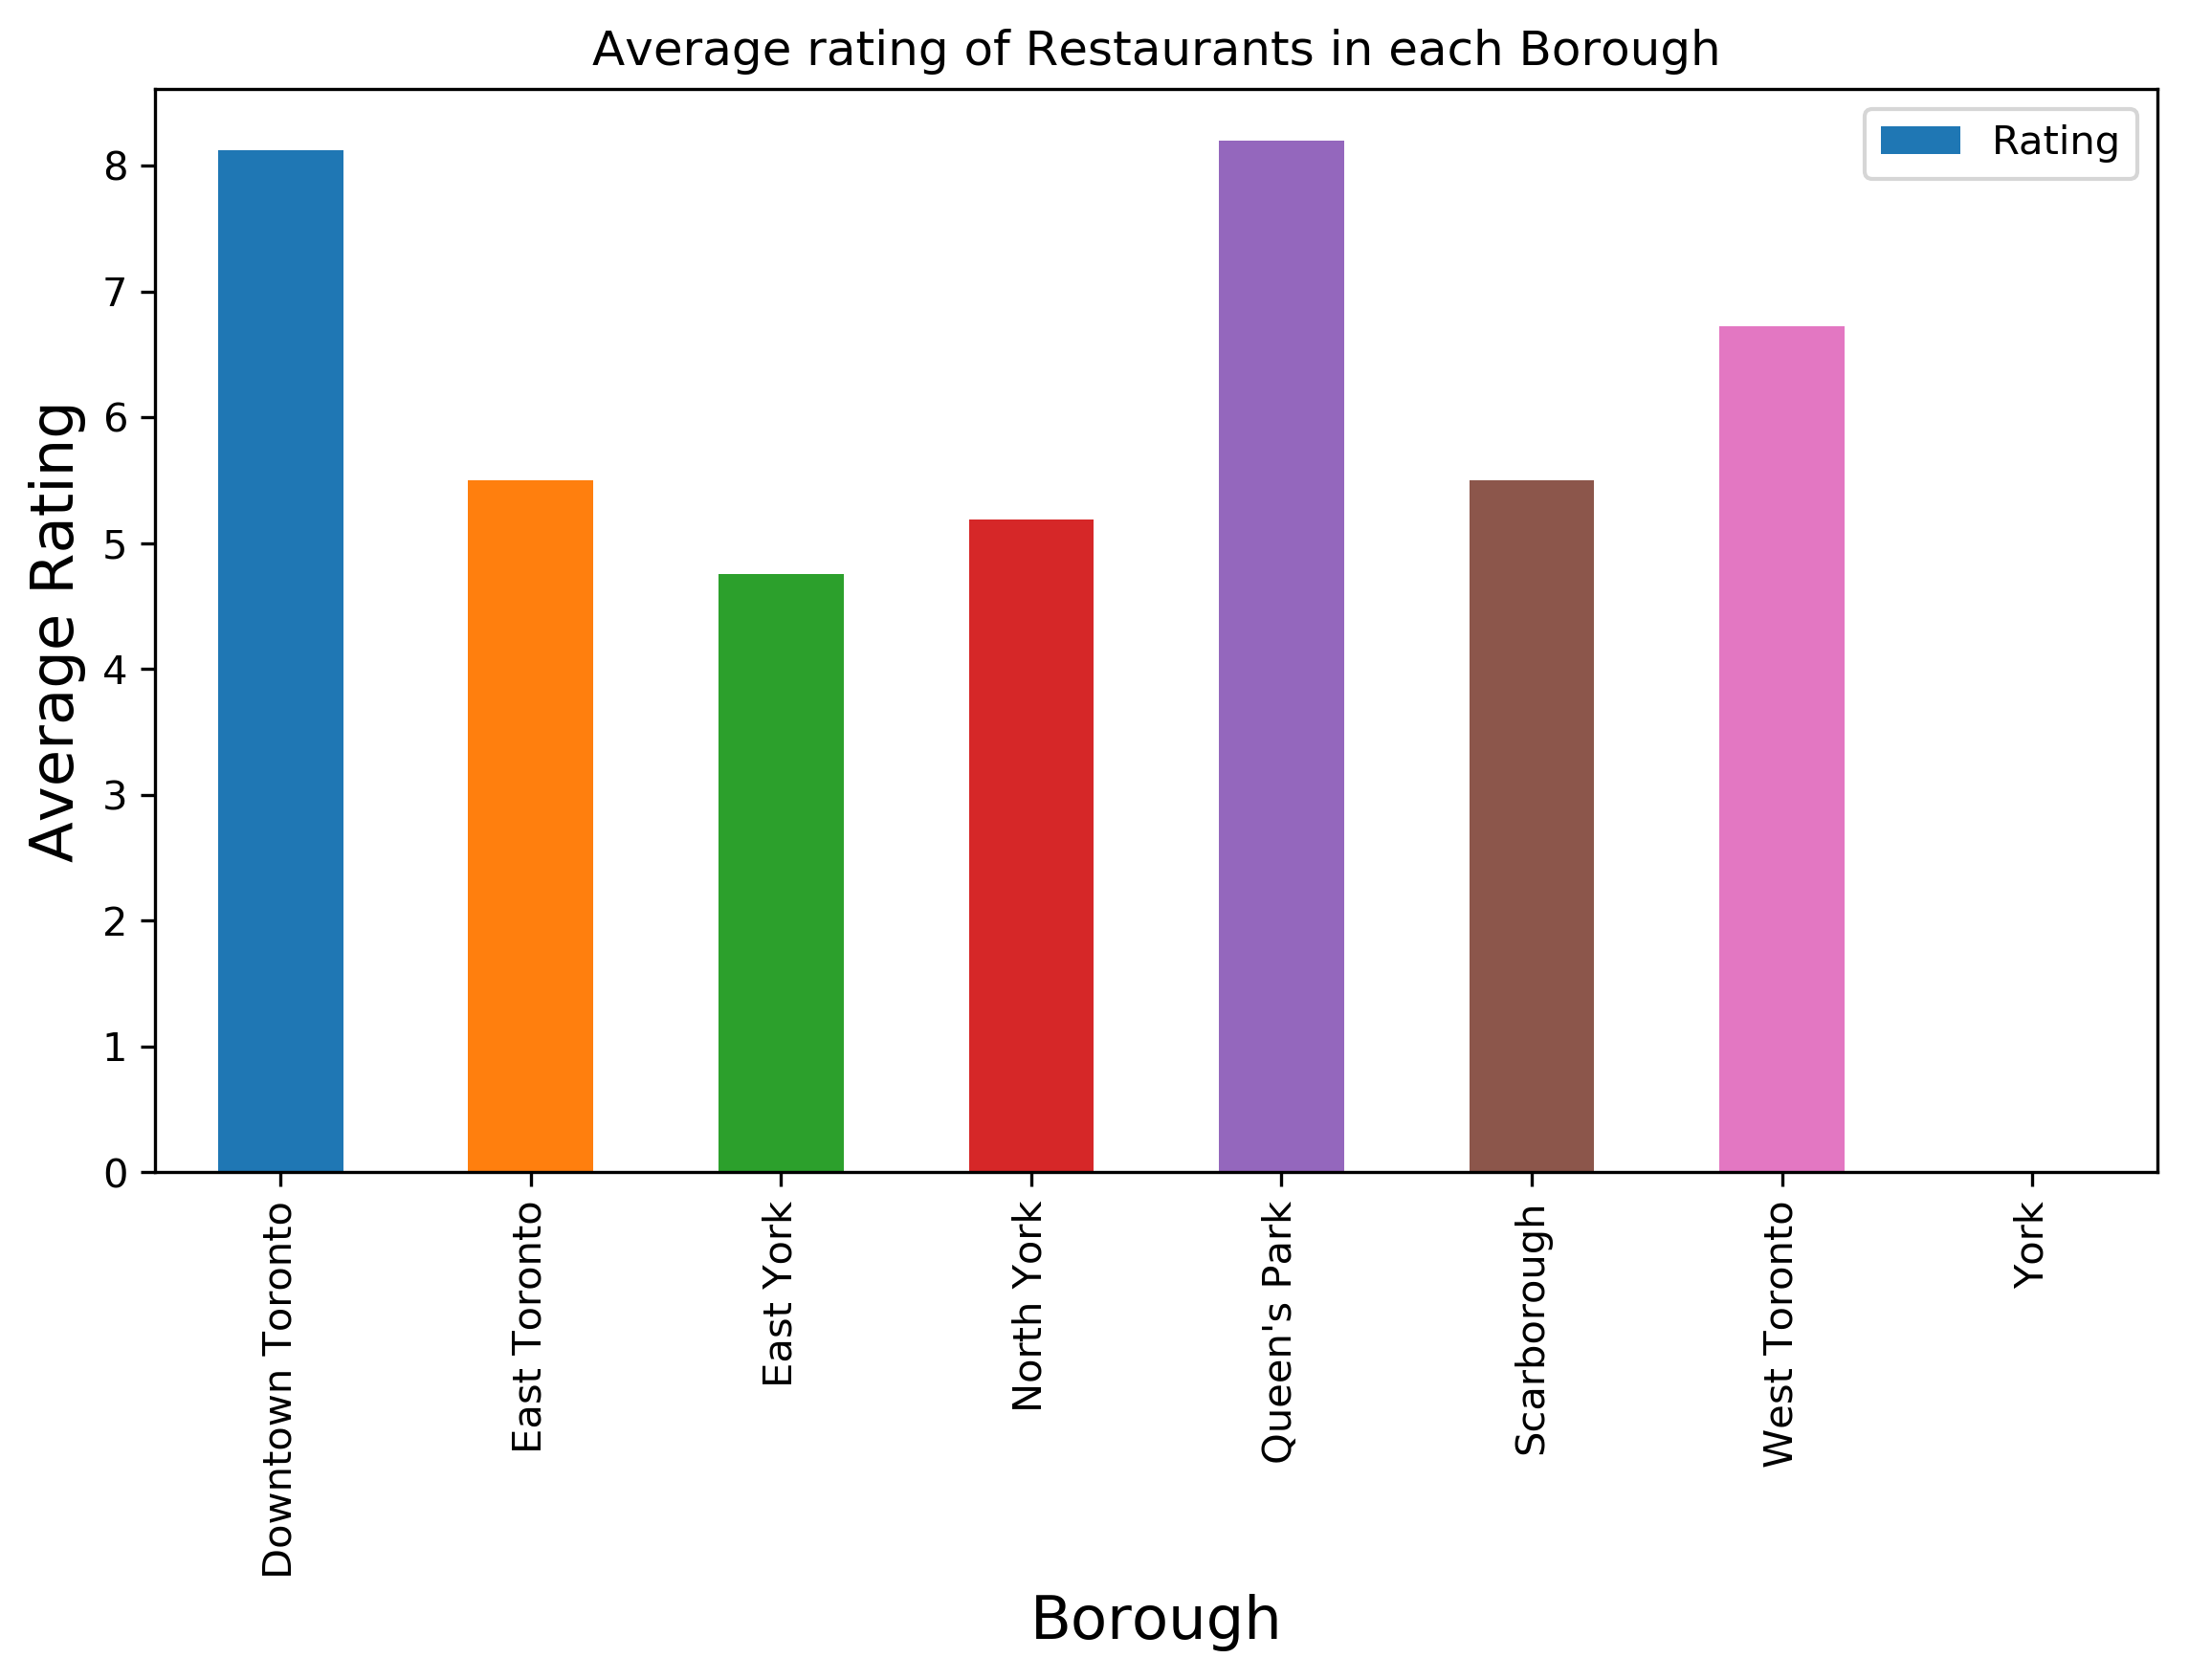

In [55]:
plt.figure(figsize=(9,5), dpi = 300)
# title
plt.title('Average rating of Restaurants in each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Restuarants_stats_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on map

In [34]:
Toronto_neighborhood_Average_Rating = Restuarants_stats_csv 
Toronto_neighborhood_Average_Rating = Toronto_neighborhood_stats[Toronto_neighborhood_stats['Average Rating']>=7.0]
Toronto_neighborhood_Average_Rating

,Neighborhood,Average Rating
0,"Adelaide, King, Richmond",8.500000
1,"Bathurst Manor, Downsview North, Wilson Heights",7.700000
2,Berczy Park,8.050000
3,Central Bay Street,8.000000
4,Christie,7.600000
9,"Flemingdon Park, Don Mills South",7.300000
11,Harbourfront,7.800000
12,"Harbourfront East, Toronto Islands, Union Station",8.040000
16,"Little Portugal, Trinity",8.400000
18,Not assigned,8.200000


In [35]:
Toronto_neighborhood_Average_Rating = pd.merge(Toronto_neighborhood_Average_Rating,df_Toronto, on='Neighborhood')
Toronto_neighborhood_Average_Rating

,Neighborhood,Average Rating,Postcode,Borough,Latitude,Longitude
0,"Adelaide, King, Richmond",8.500000,M5H,Downtown Toronto,43.650571,-79.384568
1,"Bathurst Manor, Downsview North, Wilson Heights",7.700000,M3H,North York,43.754328,-79.442259
2,Berczy Park,8.050000,M5E,Downtown Toronto,43.644771,-79.373306
3,Central Bay Street,8.000000,M5G,Downtown Toronto,43.657952,-79.387383
4,Christie,7.600000,M6G,Downtown Toronto,43.669542,-79.422564
5,"Flemingdon Park, Don Mills South",7.300000,M3C,North York,43.725900,-79.340923
6,Harbourfront,7.800000,M5A,Downtown Toronto,43.654260,-79.360636
7,"Harbourfront East, Toronto Islands, Union Station",8.040000,M5J,Downtown Toronto,43.640816,-79.381752
8,"Little Portugal, Trinity",8.400000,M6J,West Toronto,43.647927,-79.419750
9,Not assigned,8.200000,M7A,Queen's Park,43.662301,-79.389494


Also, We have the neighborhoods with average rating greater than 7.0 in

Downtown Toronto    8

East Toronto        1

North York          2

Queen's Park        1

West Toronto        1

In [36]:
Toronto_neighborhood_Average_Rating.groupby('Borough').count()['Neighborhood']

Borough
Downtown Toronto    8
North York          2
Queen's Park        1
West Toronto        1
Name: Neighborhood, dtype: int64

In [37]:
Toronto_neighborhood_Average_Rating = Toronto_neighborhood_Average_Rating.iloc[:,:6]
Toronto_neighborhood_Average_Rating_new = Toronto_neighborhood_Average_Rating.rename(columns={'Postcode_x': 'Postcode','Borough_x':'Borough','Latitude_x':'Latitude','Longitude_x':'Longitude'})
Toronto_neighborhood_Average_Rating_new

,Neighborhood,Average Rating,Postcode,Borough,Latitude,Longitude
0,"Adelaide, King, Richmond",8.500000,M5H,Downtown Toronto,43.650571,-79.384568
1,"Bathurst Manor, Downsview North, Wilson Heights",7.700000,M3H,North York,43.754328,-79.442259
2,Berczy Park,8.050000,M5E,Downtown Toronto,43.644771,-79.373306
3,Central Bay Street,8.000000,M5G,Downtown Toronto,43.657952,-79.387383
4,Christie,7.600000,M6G,Downtown Toronto,43.669542,-79.422564
5,"Flemingdon Park, Don Mills South",7.300000,M3C,North York,43.725900,-79.340923
6,Harbourfront,7.800000,M5A,Downtown Toronto,43.654260,-79.360636
7,"Harbourfront East, Toronto Islands, Union Station",8.040000,M5J,Downtown Toronto,43.640816,-79.381752
8,"Little Portugal, Trinity",8.400000,M6J,West Toronto,43.647927,-79.419750
9,Not assigned,8.200000,M7A,Queen's Park,43.662301,-79.389494


In [38]:
Toronto_neighborhood_Average_Rating_new['Label']=Toronto_neighborhood_Average_Rating_new['Neighborhood']+' , '+Toronto_neighborhood_Average_Rating_new['Borough']+'('+Toronto_neighborhood_Average_Rating_new['Average Rating'].map(str)+')'

In [39]:
Toronto_neighborhood_Average_Rating_new

,Neighborhood,Average Rating,Postcode,Borough,Latitude,Longitude,Label
0,"Adelaide, King, Richmond",8.500000,M5H,Downtown Toronto,43.650571,-79.384568,"Adelaide, King, Richmond , Downtown Toronto(8.5)"
1,"Bathurst Manor, Downsview North, Wilson Heights",7.700000,M3H,North York,43.754328,-79.442259,"Bathurst Manor, Downsview North, Wilson Height..."
2,Berczy Park,8.050000,M5E,Downtown Toronto,43.644771,-79.373306,"Berczy Park , Downtown Toronto(8.049999999999999)"
3,Central Bay Street,8.000000,M5G,Downtown Toronto,43.657952,-79.387383,"Central Bay Street , Downtown Toronto(8.0)"
4,Christie,7.600000,M6G,Downtown Toronto,43.669542,-79.422564,"Christie , Downtown Toronto(7.6)"
5,"Flemingdon Park, Don Mills South",7.300000,M3C,North York,43.725900,-79.340923,"Flemingdon Park, Don Mills South , North York(..."
6,Harbourfront,7.800000,M5A,Downtown Toronto,43.654260,-79.360636,"Harbourfront , Downtown Toronto(7.800000000000..."
7,"Harbourfront East, Toronto Islands, Union Station",8.040000,M5J,Downtown Toronto,43.640816,-79.381752,"Harbourfront East, Toronto Islands, Union Stat..."
8,"Little Portugal, Trinity",8.400000,M6J,West Toronto,43.647927,-79.419750,"Little Portugal, Trinity , West Toronto(8.3999..."
9,Not assigned,8.200000,M7A,Queen's Park,43.662301,-79.389494,"Not assigned , Queen's Park(8.2)"


In [42]:
# create map and display it
toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in Toronto_neighborhood_Average_Rating_new[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
toronto_map

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [43]:
# add pop-up text to each marker on the map
for lat, lng, label in Toronto_neighborhood_Average_Rating_new[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)        
# add incidents to map
toronto_map.add_child(incidents)

In [44]:
Toronto_neighborhood_Average_Rating_new.head()

,Neighborhood,Average Rating,Postcode,Borough,Latitude,Longitude,Label
0,"Adelaide, King, Richmond",8.50,M5H,Downtown Toronto,43.650571,-79.384568,"Adelaide, King, Richmond , Downtown Toronto(8.5)"
1,"Bathurst Manor, Downsview North, Wilson Heights",7.70,M3H,North York,43.754328,-79.442259,"Bathurst Manor, Downsview North, Wilson Height..."
2,Berczy Park,8.05,M5E,Downtown Toronto,43.644771,-79.373306,"Berczy Park , Downtown Toronto(8.049999999999999)"
3,Central Bay Street,8.00,M5G,Downtown Toronto,43.657952,-79.387383,"Central Bay Street , Downtown Toronto(8.0)"
4,Christie,7.60,M6G,Downtown Toronto,43.669542,-79.422564,"Christie , Downtown Toronto(7.6)"


In [45]:
Toronto_neighborhood_Average_Rating_new['Borough'] = Toronto_neighborhood_Average_Rating_new['Borough'].astype('str')
Toronto_neighborhood_Average_Rating_new['Average Rating'] = Toronto_neighborhood_Average_Rating_new['Average Rating'].astype('float')

In [46]:
import folium
from folium import GeoJson

toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
toronto_geo = r'simple.geojson'
#toronto_geo = r'Borough Boundaries.geojson'

toronto_map.choropleth(
    geo_data=toronto_geo,
    name = 'Toronto_Choropleth',
    data=Toronto_borough_stats,
    columns=['Borough', 'Average Rating'],
    #key_on='feature.properties.AREA_NAME',
    key_on='feature.properties.HOOD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Average Rating'
)
folium.LayerControl().add_to(toronto_map)

# display map
# as this is huge map data , we will save it to a file
toronto_map.save('Toronto_borough_rating.html')
toronto_map

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Finally, we create the map and mark which the restaurants are rating higher than 7.0. On the other hand, I interested in the North York Borough, which has many neighborhoods but a few restaurants.

In [47]:
Restuarants_NorthYork = Restuarants_stats_csv[Restuarants_stats_csv['Borough'] == 'North York']
Restuarants_NorthYork

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
4,North York,"Lawrence Heights, Lawrence Manor",4b3113e0f964a520b3ff24e3,Swiss Chalet Rotisserie & Grill,15.0,7.5,2.0
5,North York,"Lawrence Heights, Lawrence Manor",4af3820ef964a5203dee21e3,Shoeless Joe's,11.0,5.9,3.0
8,North York,Don Mills North,4b53b917f964a52038a927e3,Swiss Chalet Rotisserie & Grill,12.0,5.7,11.0
12,North York,Glencairn,0,0,0.0,0.0,0.0
13,North York,Glencairn,0,0,0.0,0.0,0.0
14,North York,"Flemingdon Park, Don Mills South",4b6315b6f964a520d6612ae3,Swiss Chalet Rotisserie & Grill,8.0,7.0,7.0
15,North York,"Flemingdon Park, Don Mills South",4c02b933310fc9b64fe1c461,JOEY Don Mills,193.0,8.3,128.0
16,North York,"Flemingdon Park, Don Mills South",4b4bd8c0f964a52078a926e3,Jack Astor's Bar & Grill,83.0,6.6,49.0
31,North York,"Bathurst Manor, Downsview North, Wilson Heights",4b65c410f964a52050fe2ae3,Bagel Plus,11.0,7.7,4.0
37,North York,"Fairview, Henry Farm, Oriole",5650fa8e498e405c38a5e6d4,Thai Express,0.0,6.3,0.0


We can drop index 3,4,9 and 11 because data was wrong.

In [52]:
Restuarants_NorthYork_new = Restuarants_NorthYork.drop(Restuarants_NorthYork.index[[3,4,9,11]])
Restuarants_NorthYork_new

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
4,North York,"Lawrence Heights, Lawrence Manor",4b3113e0f964a520b3ff24e3,Swiss Chalet Rotisserie & Grill,15.0,7.5,2.0
5,North York,"Lawrence Heights, Lawrence Manor",4af3820ef964a5203dee21e3,Shoeless Joe's,11.0,5.9,3.0
8,North York,Don Mills North,4b53b917f964a52038a927e3,Swiss Chalet Rotisserie & Grill,12.0,5.7,11.0
14,North York,"Flemingdon Park, Don Mills South",4b6315b6f964a520d6612ae3,Swiss Chalet Rotisserie & Grill,8.0,7.0,7.0
15,North York,"Flemingdon Park, Don Mills South",4c02b933310fc9b64fe1c461,JOEY Don Mills,193.0,8.3,128.0
16,North York,"Flemingdon Park, Don Mills South",4b4bd8c0f964a52078a926e3,Jack Astor's Bar & Grill,83.0,6.6,49.0
31,North York,"Bathurst Manor, Downsview North, Wilson Heights",4b65c410f964a52050fe2ae3,Bagel Plus,11.0,7.7,4.0
38,North York,"Northwood Park, York University",4d02ddfbc2e53704abf9ad67,Elite Restaurant,4.0,7.2,5.0


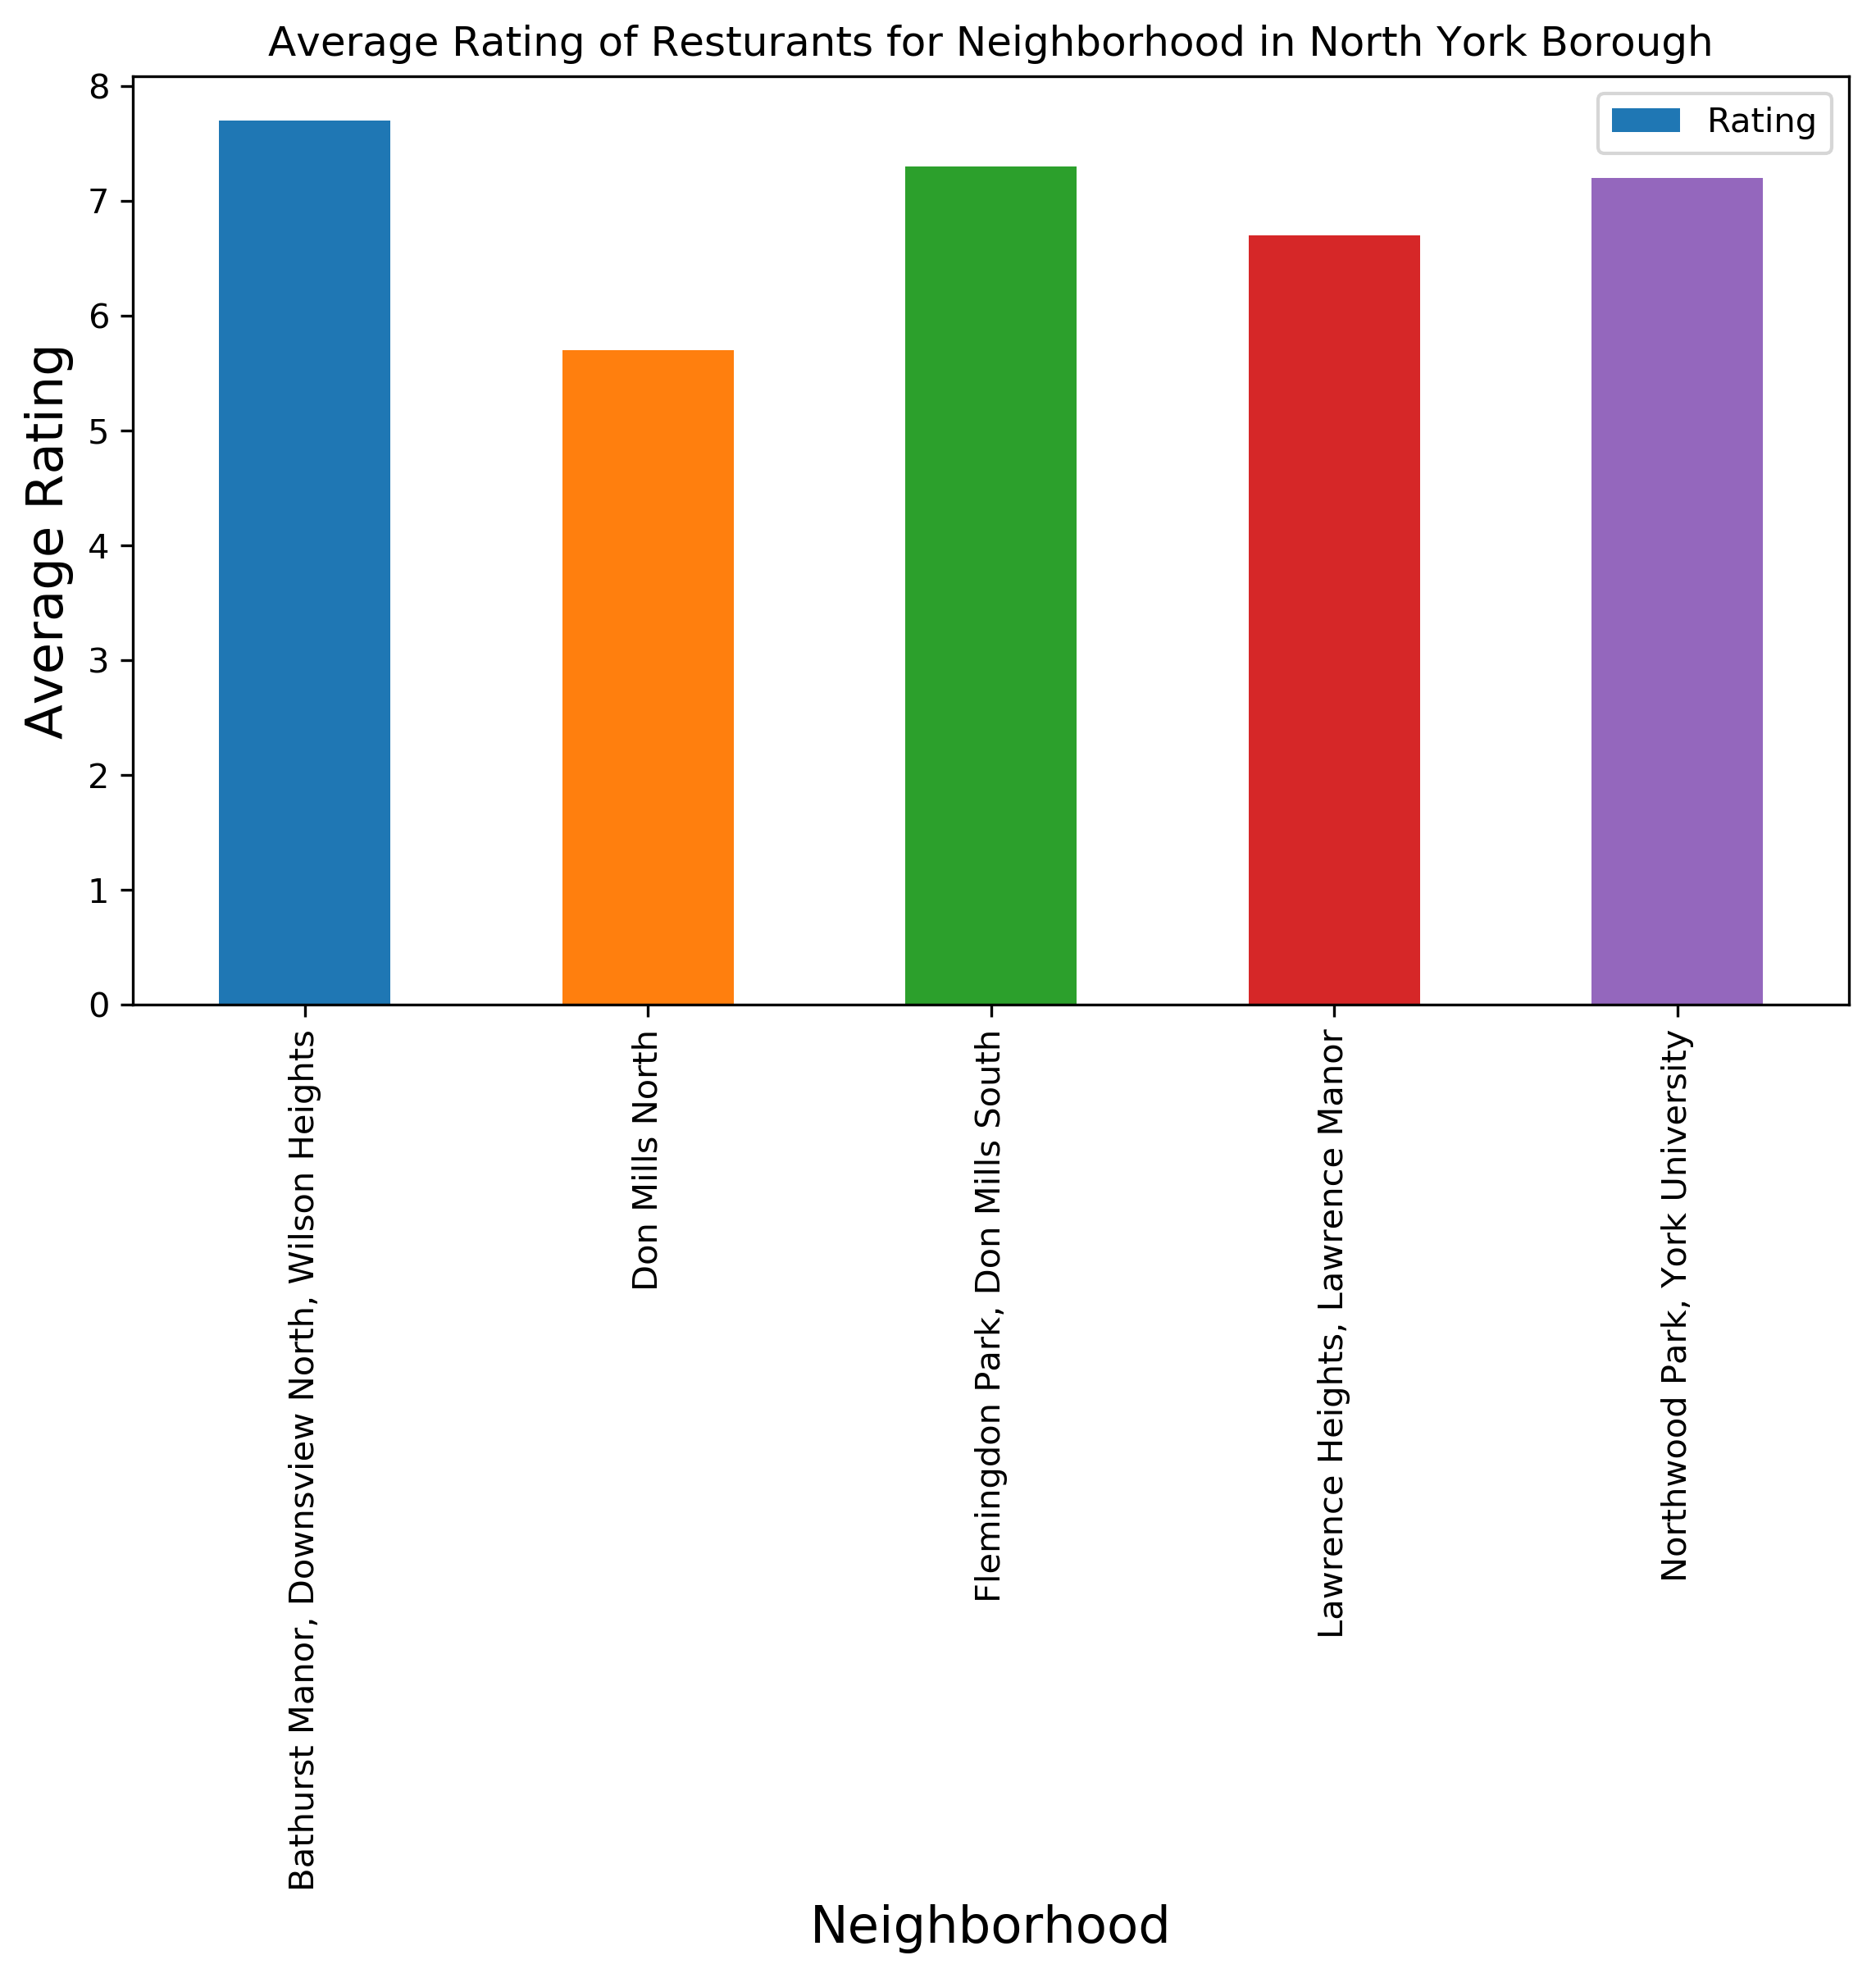

In [53]:
plt.figure(figsize=(9,5), dpi = 300)
# title
plt.title('Average Rating of Resturants for Neighborhood in North York Borough')
#giving a bar plot
Restuarants_NorthYork_new.groupby('Neighborhood').mean()['Rating'].plot(kind='bar')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#legend
plt.legend()
#displays the plot
plt.show()

# Conclusion

We search the number of restaurants in Toronto, which we interest in Downtown and North York with reasoning by
- The number of Restaurants in Borough or Neighborhood
-  Rating and Like restaurants

Also, we find high rating restaurants in Downtown, which we interest in opening the restaurants. On the other hand, we look at North York, the number of restaurants is less than Downtown Toronto. However,  neighborhoods in North York are over than Downtown Toronto.

We decide the potential opening the restaurants following:
- Downtown Toronto has a great location and reputation of restaurants because most restaurants placed in Downtown Toronto. If you want a good location, Downtown Toronto is an appropriate place for opening restaurants.

- Another choice is North York, which having many neighborhoods but having few restaurants.

Finally, we don't use the population in Toronto, salary, and housing prices because I can't find these. Therefore, the results represent the data that the accuracy of data depends on the pure data provided by Foursquare.

# File_Attach 
1. 